##### Задача - построить модель для расчета xG, базируясь на предоставленных данных.
##### Если вы не знаете, что такое xG - это вероятность того, что удар игрока будет голом. 
##### https://www.sports.ru/tribuna/blogs/vadimlukomski/859121.html - это интуитивное объяснение возможной модели. 
 
##### Задание должно быть выполнено в Jupyter Notebook, код должен быть на версии Python 3.4 и выше. Легенда для данных прикреплена вместе с документом. Если вы используете дополнительные библиотеки, кроме стандартных, пожалуйста, опишите явно в начале ноутбука, что вы используете. 
##### Решение должно включать в себя все шаги для корректного построения модели, начиная от предобработки данных, заканчивая шагом predict. Нам очень хотелось бы увидеть, как вы принимаете решения и рассуждаете, поэтому, пожалуйста, комментируйте свой код c помощью Markdown. 
##### Дополнительными плюсами для задания являются визуализации и анализ решения со стороны бизнеса.
 
##### Легенда:
##### event - событие
##### is_goal - результат (гол / не гол)
##### period - период события
##### time - время события в секундах (с начала периода)
##### distance - дистанция броска
##### angle - угол броска (схема)
##### is_rebound - был ли бросок добиванием
##### is_pass_before - был ли бросок после передачи
##### is_cross_line - были ли бросок после пересечения шайбой оси Х (проходи от центра ворот до середины площадки)
##### is_one_touch - был ли бросок в одно касание
##### is_fast_attack - была ли атака без передач назад

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Считаем наш датасет и выведем первые 5 строк по нему

In [2]:
df = pd.read_csv('C:/Datasets/shots.csv', sep = ',')

In [3]:
df['is_goal'].value_counts()

False    13687
True       723
Name: is_goal, dtype: int64

In [4]:
df.head()

,event,is_goal,period,time,distance,angle,is_rebound,is_pass_before,is_cross_line,is_one_touch,is_fast_attack
0,Shot Attempt - Wide left,False,1,1071.6,17.4,44.492971,False,False,False,False,False
1,Shot Attempt - Blocked,False,1,519.2,12.9,46.694647,False,False,False,False,False
2,Shot Attempt - Deflected,False,2,742.9,20.6,59.284706,False,False,False,False,False
3,Shot Attempt - Blocked,False,1,210.1,16.6,5.419532,False,True,False,True,False
4,Shot Attempt - Deflected,False,2,599.1,20.1,64.221569,False,False,False,False,False


### Выведем количество пропущенных значений в каждом из предикторов

In [5]:
df.isnull().sum()

event             0
is_goal           0
period            0
time              0
distance          0
angle             0
is_rebound        0
is_pass_before    0
is_cross_line     0
is_one_touch      0
is_fast_attack    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14410 entries, 0 to 14409
Data columns (total 11 columns):
event             14410 non-null object
is_goal           14410 non-null bool
period            14410 non-null int64
time              14410 non-null float64
distance          14410 non-null float64
angle             14410 non-null float64
is_rebound        14410 non-null bool
is_pass_before    14410 non-null bool
is_cross_line     14410 non-null bool
is_one_touch      14410 non-null bool
is_fast_attack    14410 non-null bool
dtypes: bool(6), float64(3), int64(1), object(1)
memory usage: 647.4+ KB


### Для корректного построения модели нам необходимо провести предобработку наших данных. Мы видим, что признак 'event' является категориальным, а признаки 'is_goal', 'is_rebound', 'is_pass_before', 'is_cross_line', 'is_one_touch', 'is_fast_attack' являются бинарными. 
### Для построения модели необходимо будет перевести их в вещественные.

### Выведем перечень уникальных значений предиктора 'event'

In [7]:
df['event'].value_counts()

Shot Attempt - Blocked          3842
Shot Attempt - Upper right      1490
Shot Attempt - Upper left       1343
Shot Attempt - Lower left       1274
Shot Attempt - Deflected        1151
Shot Attempt - Lower right      1137
Shot Attempt - Bottom middle     986
Shot Attempt - Wide right        951
Shot Attempt - Wide left         944
Shot Attempt - Top middle        894
Shot Attempt - Over the net      398
Name: event, dtype: int64

### Присвоим каждой категории данного предиктора уникальное целочисленное значение. 

In [8]:
dict_events = {'Shot Attempt - Wide left':0,
               'Shot Attempt - Blocked':1,
               'Shot Attempt - Deflected':2, 
               'Shot Attempt - Wide right':3,
               'Shot Attempt - Lower right':4, 
               'Shot Attempt - Bottom middle':5,
               'Shot Attempt - Over the net':6, 
               'Shot Attempt - Upper right':7,
               'Shot Attempt - Upper left':8, 
               'Shot Attempt - Lower left':9,
               'Shot Attempt - Top middle':10}
df['event'] = df['event'].map(dict_events)

### Теперь в бинарных предикторах заменим True и False на 1 и 0.

In [9]:
df =  df.applymap(lambda x: 1 if x == True else x)
df =  df.applymap(lambda x: 0 if x == False else x)

### Создадим некоторые новые предикторы на основе имеющихся. Например добавим косинус угла удара по воротам (признак 'angle').
### После этого вычислим расстояние до линии, проходящей через центр ворот (distance*cos(angle)).

In [10]:
df['rad'] = df['angle']/57.297
df.drop('angle', axis = 1, inplace = True) 
# Для уменьшения мультиколлинеарности нужно удалить признак angle, т.к. он будет линейно зависимым с новым признаком rad.

df['cos_rad'] = np.cos(df['rad'])
df['distance_center'] = df['cos_rad'] * df['distance']

In [11]:
df.head()

,event,is_goal,period,time,distance,is_rebound,is_pass_before,is_cross_line,is_one_touch,is_fast_attack,rad,cos_rad,distance_center
0,0,0,1,1071.6,17.4,0,0,0,0,0,0.776532,0.713348,12.412256
1,1,0,1,519.2,12.9,0,0,0,0,0,0.814958,0.685899,8.848097
2,2,0,2,742.9,20.6,0,0,0,0,0,1.034691,0.510791,10.522302
3,1,0,1,210.1,16.6,0,1,0,1,0,0.094587,0.995530,16.525798
4,2,0,2,599.1,20.1,0,0,0,0,0,1.120854,0.434914,8.741764


### Произведем разбиение нашего датасета на обучающую и тестовую подвыборки. Также выделим нашу целевую переменную - это будет столбец 'is_goal'.

In [28]:
train = df.sample(frac = 0.7, random_state = 200)
test = df.drop(train.index)

y_train = train['is_goal']
train.drop('is_goal', axis=1, inplace = True)

y_test = test['is_goal']
test.drop('is_goal', axis=1, inplace = True)

### Произведем кодирование переменных 'event' и 'period' относительными частотами (метод frequency_encoding). 
### Данное кодирование необходимо проводить после разбиения на обучение и тест, поскольку мы не можем брать данные для преобразований из тестовой выборки (нельзя использовать данные из 'будущего').

In [29]:
for i in ['event', 'period']:
    freq_encoding = train[i].value_counts() / len(train[i])
    train[i + '+' + 'freq'] = train[i].map(freq_encoding)
    test[i + '+' + 'freq'] = test[i].map(freq_encoding)
    
train.drop(['event', 'period'], axis = 1, inplace = True)
test.drop(['event', 'period'], axis = 1, inplace = True)  

### Посмотрим на распределение наших вещественных признаков ('time', 'distance', 'rad', 'cos_rad', 'distance_center'). Для этого импортируем библиотеку seaborn, построим гистограмму распределения наших признаков, а также сравним его с нормальным распределением.
### Также построим график квантиль-квантиль для понимания, все ли данные в предикторе лежат на кривой, соответствующей нормальному распределению, и если не все, то насколько сильно они отклоняются от нее.

C:\Users\mi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


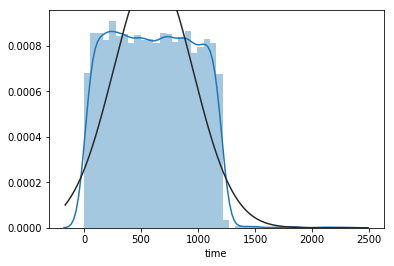

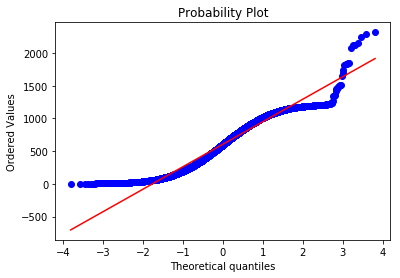

In [14]:
import seaborn as sns

# импортируем norm и stats
from scipy.stats import norm
from scipy import stats

# строим гистограмму распределения и график
# квантиль-квантиль для наших вещественных переменных
sns.distplot(train['time'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['time'], plot=plt)

C:\Users\mi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


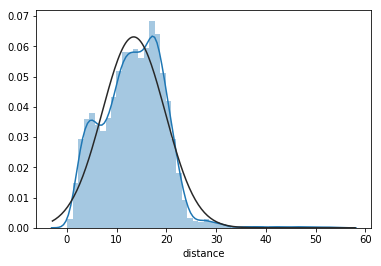

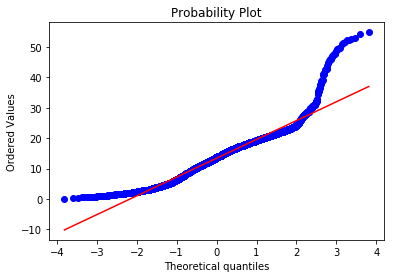

In [15]:
sns.distplot(train['distance'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['distance'], plot=plt)

C:\Users\mi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


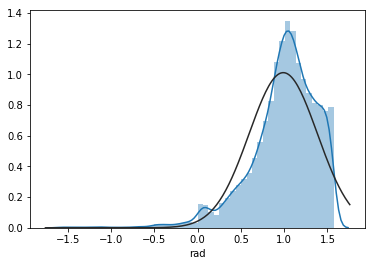

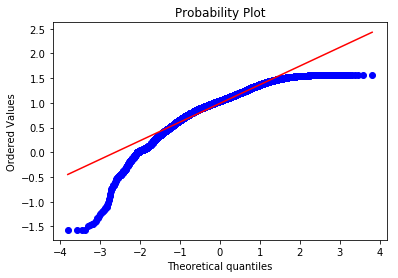

In [16]:
sns.distplot(train['rad'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['rad'], plot=plt)

C:\Users\mi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


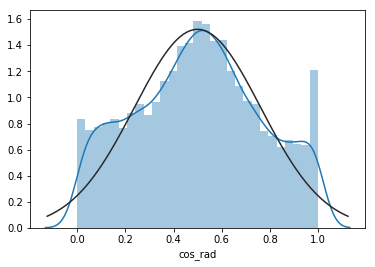

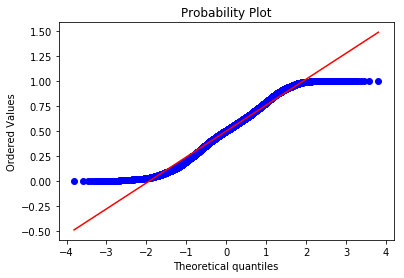

In [17]:
sns.distplot(train['cos_rad'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['cos_rad'], plot=plt)

C:\Users\mi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


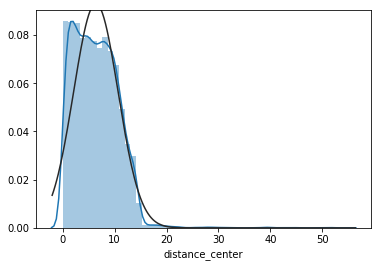

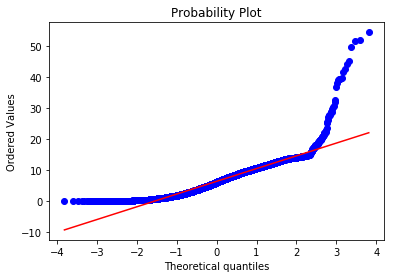

In [18]:
sns.distplot(train['distance_center'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['distance_center'], plot=plt)

### Судя по графикам квантиль-квантиль наши вещественные признаки не совсем подчиняются нормальному распределению. 
### Воспользуемся преобразованием Бокса-Кокса для преобразования наших вещественных данных к нормальному распределению.

In [30]:
train['rad'].replace(0.0, 0.001, inplace = True) # Заменяем 0 на стремящееся к нулю значение

from scipy.stats import boxcox

for i in ['time', 'distance', 'rad', 'cos_rad', 'distance_center']:
    transformed, lam = boxcox(np.absolute(train[i]))
    print('predictor:', i, 'Lambda: %f' % lam)
    if lam < -0.25:
        train[i] = np.sign(train[i]) * (np.absolute(train[i])** (-1/2))
        test[i] = np.sign(test[i]) * (np.absolute(test[i])** (-1/2))
    if -0.25 <= lam <= 0.25:
        train[i] = np.log(np.absolute(train[i])+ 0.001)
        test[i] = np.log(np.absolute(test[i])+ 0.001)
    if 0.25 < lam < 0.75:
        train[i] = np.sign(train[i]) * (np.absolute(train[i])** (1/2))
        test[i] = np.sign(test[i]) * (np.absolute(test[i])** (1/2))

predictor: time Lambda: 0.685768
predictor: distance Lambda: 0.708826
predictor: rad Lambda: 1.354691
predictor: cos_rad Lambda: 0.766999
predictor: distance_center Lambda: 0.517407


In [20]:
train.head()

,time,distance,is_rebound,is_pass_before,is_cross_line,is_one_touch,is_fast_attack,rad,cos_rad,distance_center,event+freq,period+freq
11411,30.890128,4.549725,0,1,0,1,0,1.162622,0.396934,2.866449,0.078120,0.323585
4479,30.755487,3.376389,0,0,0,0,0,0.628075,0.809160,3.037174,0.090116,0.357589
12555,31.300160,2.588436,0,0,0,0,1,1.030355,0.514515,1.856677,0.103698,0.307029
1007,32.939338,3.701351,0,0,0,0,1,0.601442,0.824521,3.360942,0.065332,0.357589
11478,9.808160,4.037326,0,0,0,0,0,0.675777,0.780221,3.566175,0.078120,0.307029


### Для приведения наших данных к одному масштабу проведем стандартизацию.

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(train)

train_s = scaler.transform(train)
test_s = scaler.transform(test)

### Построим модель логистической регрессии. Параметры подберем с помощью решетчатого поиска (grid_search), будем использовать кросс-валидацию из 10 блоков.
### Будем использовать метрику качества - AUC_ROC.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

logreg_grid = LogisticRegression()

param_grid = {'C': [0.01, 0.1, 0.5, 1, 2], 'penalty':['l1', 'l2']} # Задаем решетку гиперпараметров. 

stratcv = StratifiedKFold(n_splits=10) # Указываем количество блоков для кросс-валидации.

#создаем экземпляр класса GridSearchCV
grid_search = GridSearchCV(logreg_grid, param_grid, 
                           scoring='roc_auc', 
                           n_jobs=-1, cv=stratcv)

grid_search.fit(train_s, y_train)

test_score = roc_auc_score(y_test, grid_search.predict_proba(test_s)[:, 1])
 #смотрим результаты GridSearchCV
print('AUC на тестовой выборке: {:.3f}'.format(test_score))
print('Наилучшее значение гиперпараметров: {}'.format(grid_search.best_params_))
print('Наилучшее значение AUC: {:.3f}'.format(grid_search.best_score_))

AUC на тестовой выборке: 0.759
Наилучшее значение гиперпараметров: {'C': 0.1, 'penalty': 'l1'}
Наилучшее значение AUC: 0.771


In [43]:
import statistics
print(statistics.mean(auc))

0.7624871060996348


In [42]:
auc = []
for i in range(1,500):
    X_test = (pd.DataFrame(test_s)).sample(frac = 0.15, random_state = i)
    ydf = pd.DataFrame(y_test)
    y_test_1 = ydf.iloc[list(X_test.index)]
    test_score = roc_auc_score(y_test_1, grid_search.predict_proba(X_test)[:, 1])
    auc.append(test_score)

In [143]:
tr.sort_index()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.496081,1.078364,-0.250145,-0.454668,-0.458948,-0.597542,-0.399114,0.114941,0.042188,0.980415,-0.583318,0.757399
6,-0.370716,-0.367172,3.997685,-0.454668,-0.458948,1.673523,-0.399114,0.386498,-0.319356,-0.321507,-0.756777,-0.084091
9,-1.418262,0.410228,-0.250145,-0.454668,2.178894,-0.597542,2.505549,1.343138,-1.708224,-1.625749,1.624233,0.757399
12,0.025401,1.078364,-0.250145,-0.454668,-0.458948,-0.597542,-0.399114,0.215996,-0.089965,0.856260,1.624233,0.757399
19,0.162703,-0.384154,-0.250145,-0.454668,-0.458948,-0.597542,-0.399114,-2.137719,1.867332,0.905819,1.624233,-0.084091
20,0.386291,1.335219,-0.250145,-0.454668,-0.458948,-0.597542,-0.399114,0.283279,-0.179564,0.945765,1.624233,-0.084091
28,0.584035,1.220078,-0.250145,-0.454668,-0.458948,-0.597542,-0.399114,0.228389,-0.106375,0.939825,1.624233,-0.084091
29,-0.994317,1.369267,-0.250145,-0.454668,-0.458948,-0.597542,-0.399114,0.015145,0.169659,1.315136,-0.583318,-0.084091
46,-0.418334,0.108622,-0.250145,-0.454668,2.178894,-0.597542,2.505549,-1.000279,1.252631,1.063510,1.624233,-0.084091
47,-0.231818,-0.898980,3.997685,-0.454668,-0.458948,1.673523,-0.399114,-2.359039,1.901553,0.397098,-0.698958,-0.084091


### Попробуем построить более сложную модель, основанную на алгоритме градиентного бустинга.
### С помощью кросс-валидации и решетчатого поиска найдем основные параметры модели - max_depth(максимальная глубина деревьев) и learning_rate(шаг обучения).
### Также зададим некоторые начальные параметры, напр. количество итераций(n_estimators), часть наблюдений, участвующих при построении каждого дерева, параметры регуляризации (reg_alpha и req_lambda).

In [43]:
import xgboost as XGB
Boost = XGB.XGBClassifier(reg_alpha=1, reg_lambda=10, n_jobs=-1, 
                          min_samples_leaf = 2, min_samples_split = 5, 
                          n_estimators = 1000, learning_rate = 0.01, max_depth = 3, subsample = 0.9, colsample_bylevel = 0.9,colsample_bytree=0.8)

param_grid = {'n_estimators' : [500, 700, 900, 1000, 5000]}

stratcv = StratifiedKFold(n_splits=3) 


grid_search = GridSearchCV(Boost, param_grid, 
                           scoring='roc_auc', 
                           n_jobs=-1, cv=stratcv)

grid_search.fit(train_s, y_train)

test_score = roc_auc_score(y_test, grid_search.predict_proba(test_s)[:, 1])

print('AUC на тестовой выборке: {:.3f}'.format(test_score))
print('Наилучшее значение гиперпараметров: {}'.format(grid_search.best_params_))
print('Наилучшее значение AUC: {:.3f}'.format(grid_search.best_score_))

AUC на тестовой выборке: 0.842
Наилучшее значение гиперпараметров: {'n_estimators': 1000}
Наилучшее значение AUC: 0.850


### Выведем важности предикторов - т.е. вклад каждого предиктора в прогноз.

In [315]:
feat_labels = train.columns
# записываем важности
importances =  B.feature_importances_
# сортирум важности по убыванию
indices = np.argsort(importances)[::-1]
# сопоставляем важности названиям предикторов
for f in range(train.shape[1]):
    print('%2d) %-*s %f' % (f + 1, 35,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) event+freq                          0.229117
 2) time                                0.183241
 3) distance                            0.172191
 4) distance_center                     0.146115
 5) rad                                 0.122867
 6) cos_rad                             0.050650
 7) is_one_touch                        0.028993
 8) period+freq                         0.023866
 9) is_cross_line                       0.014408
10) is_rebound                          0.012022
11) is_fast_attack                      0.009105
12) is_pass_before                      0.007425


### Визуализируем важности предикторов.

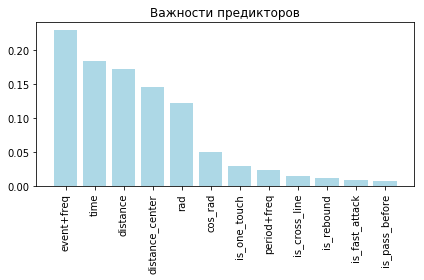

In [316]:
# задаем заголовок диаграммы
plt.title('Важности предикторов')
# настраиваем столбики  
plt.bar(range(train.shape[1]), importances[indices],
              color='lightblue', align='center')
# настраиваем метки оси x 
plt.xticks(range(train.shape[1]),
           feat_labels[indices], rotation=90)
# задаем пределы значений оси x
plt.xlim([-1, train.shape[1]])
# функция tight_layout позволяет оптимально позиционировать элементы графика на рисунке,
# например, чтобы метки оси не наезжали друг друга и пр. 
plt.tight_layout()
# выводим диаграмму
plt.show()

### Из построенной диаграммы видно, что наибольший вклад в прогноз вносят такие предикторы, как:  

### 1 - Относительная частота типа эпизода;
### 2 - Время; 
### 3 - Дистанция; 
### 4 - Дистанция до прямой, проходящей через центр ворот;
### 5 - Угол удара;

### Соответственно наиболее важные данные, это тип, время эпизода, расстояние до ворот, а также угол удара.